In [10]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import RocCurveDisplay

from scipy.stats import pearsonr

import seaborn

import matplotlib.pyplot as plt

In [3]:
toden = pd.read_csv('gsea outputs/Toden.Pathways3090.gct', skiprows = 2,index_col = 0, sep = '\t').drop('Description',axis = 1).T
silver = pd.read_csv('gsea outputs/Silver.Pathways3090.gct', skiprows = 2,index_col = 0, sep = '\t').drop('Description',axis = 1).T
burgos = pd.read_csv('gsea outputs/Burgos.Pathways3090.gct', skiprows = 2,index_col = 0, sep = '\t').drop('Description',axis = 1).T


In [4]:
toden_counts = pd.read_csv('cleaned_tolden_data_col_fixed.csv', index_col = 0)['hasAD']
silver_counts = pd.read_csv('cleaned_silver_data_counts.csv', index_col = 0)['hasAD']
burgos_counts = pd.read_csv('cleaned_burgos_data_counts.csv', index_col = 0)['hasAD']

In [5]:
toden = toden.loc[toden_counts.index]
silver = silver.loc[silver_counts.index]
burgos = burgos.loc[burgos_counts.index]

In [6]:
X = toden
y = toden_counts.loc[X.index]

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.2, random_state=666)


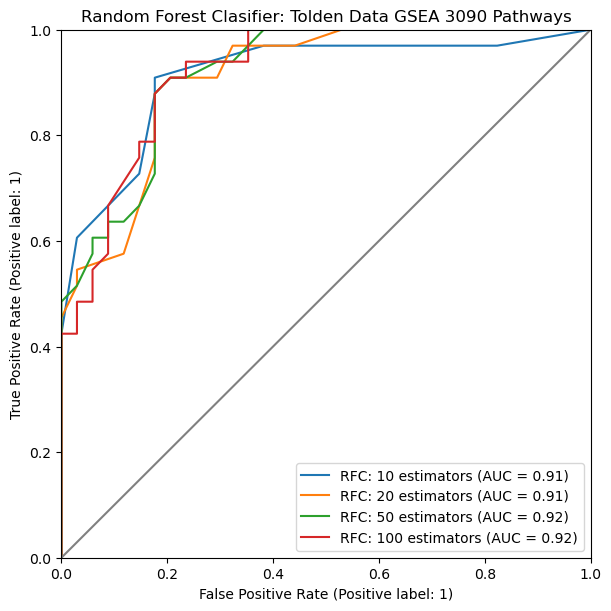

In [8]:
fig,ax = plt.subplots(1,1,constrained_layout = True)
fig.set_size_inches((6,6))

classifiers = {}

for n in [10,20,50,100]:

    rfc = RF(n_estimators=n, random_state=666)
    rfc.fit(X_train, y_train)

    y_pred = [x[1] for x in rfc.predict_proba((X_test))]

    display = RocCurveDisplay.from_predictions(
        y_test,
        y_pred,
        name='RFC: {n} estimators'.format(n=n),
        ax=ax
    )
    
    classifiers[n] = rfc

ax.set_xlim((0,1))
ax.set_ylim((0,1))

ax.plot([0,1],[0,1], color = 'grey')

ax.set_title('Random Forest Clasifier: Tolden Data GSEA 3090 Pathways')

plt.show()

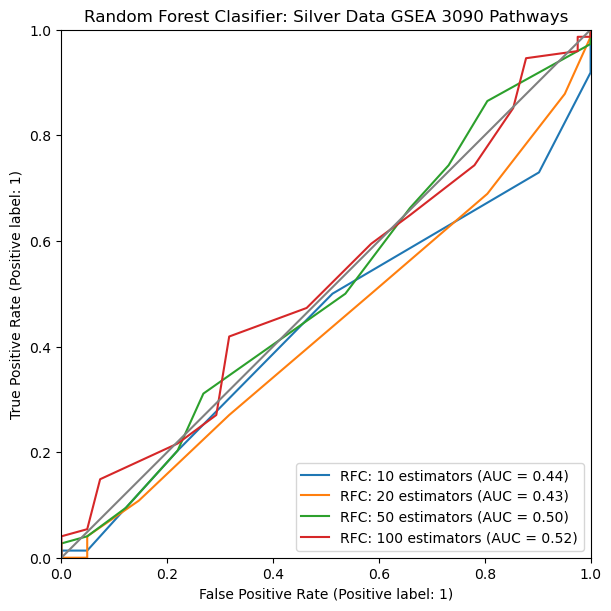

In [9]:
X = silver
y = silver_counts.loc[silver.index]

fig,ax = plt.subplots(1,1,constrained_layout = True)
fig.set_size_inches((6,6))

for n in classifiers:

    rfc = classifiers[n]

    y_pred = [x[1] for x in rfc.predict_proba((X))]

    display = RocCurveDisplay.from_predictions(
        y,
        y_pred,
        name='RFC: {n} estimators'.format(n=n),
        ax=ax
    )
    
    classifiers[n] = rfc

ax.set_xlim((0,1))
ax.set_ylim((0,1))

ax.plot([0,1],[0,1], color = 'grey')

ax.set_title('Random Forest Clasifier: Silver Data GSEA 3090 Pathways')

plt.show()

In [11]:
toden_corr = pd.DataFrame({gs:list(pearsonr(toden[gs].values, toden_counts.loc[toden.index].values))
 for gs in toden}).rename({0:'R',1:'pval'}).T.sort_values(by = 'R')

In [12]:
silver_corr = pd.DataFrame({gs:list(pearsonr(silver[gs].values, silver_counts.loc[silver.index].values))
 for gs in silver}).rename({0:'R',1:'pval'}).T.sort_values(by = 'R')

In [13]:
burgos_corr = pd.DataFrame({gs:list(pearsonr(burgos[gs].values, burgos_counts.loc[burgos.index].values))
 for gs in burgos}).rename({0:'R',1:'pval'}).T.sort_values(by = 'R')

<AxesSubplot:>

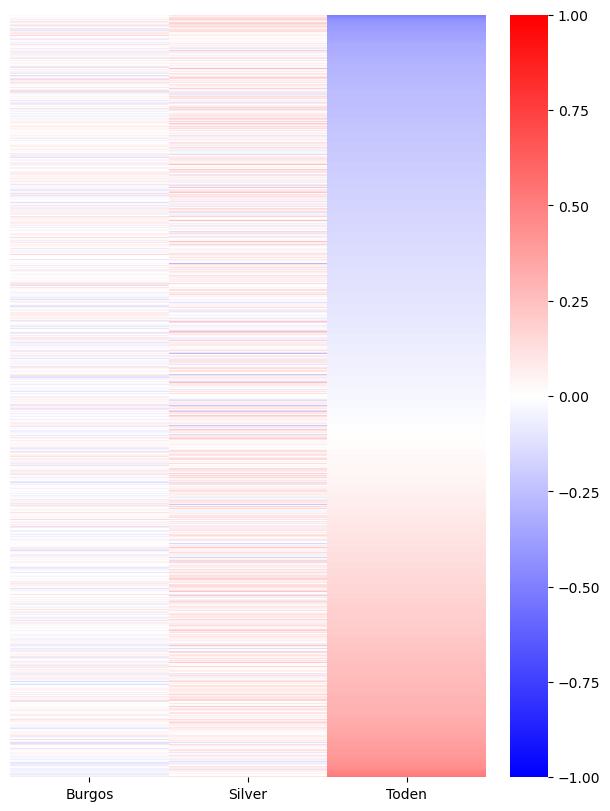

In [14]:
graph_df = pd.DataFrame({'Burgos':burgos_corr['R'],'Silver':silver_corr['R'],'Toden':toden_corr['R']}).sort_values(by = 'Toden')

fig,ax = plt.subplots(1,1,constrained_layout = True, figsize = (6,8))

seaborn.heatmap(graph_df, cmap = 'bwr', vmin = -1,vmax = 1,center = 0,
               ax=ax, annot = False, yticklabels = False)

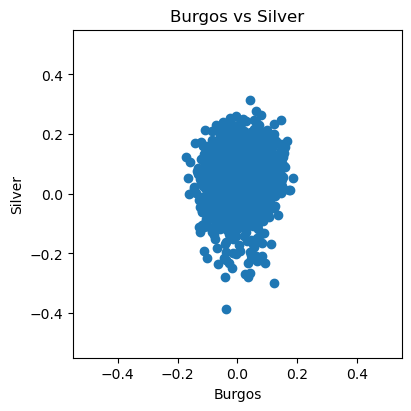

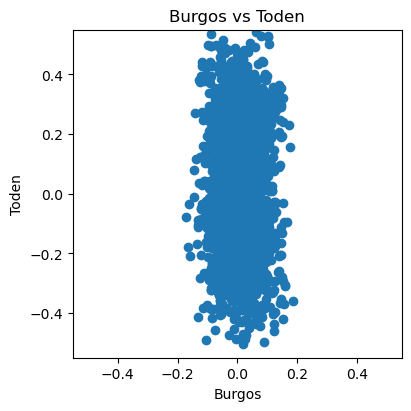

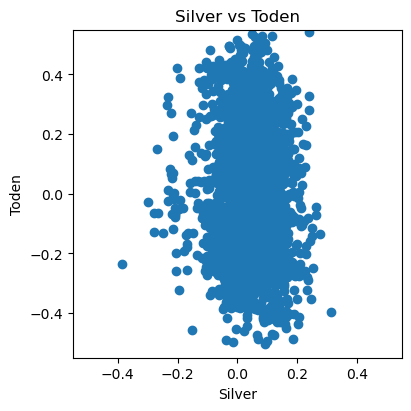

In [17]:
for xcol in graph_df:
    for ycol in graph_df:
        if xcol<ycol:
            fig,ax = plt.subplots(1,1,constrained_layout = True, figsize = (4,4))


            ax.scatter(graph_df[xcol],graph_df[ycol])
            ax.set_xlabel(xcol)
            ax.set_ylabel(ycol)
            
            ax.set_xlim((-0.55,0.55))
            ax.set_ylim((-0.55,0.55))
            
            ax.set_title(xcol+' vs '+ycol)

            plt.show()

In [31]:
print((graph_df>0.2).value_counts()) #7 pathways have pos correlation with phenotype in SIlver and Toden
graph_df[(graph_df['Silver']>0.2) & (graph_df['Toden']>0.2)]

Burgos  Silver  Toden
False   False   False    2007
                True      507
        True    False      40
                True        7
dtype: int64


,Burgos,Silver,Toden
WP_INFLAMMATORY_BOWEL_DISEASE_SIGNALING,0.028257,0.202375,0.206060
REACTOME_CHONDROITIN_SULFATE_DERMATAN_SULFATE_METABOLISM,-0.070052,0.230978,0.227315
WP_GASTRIC_CANCER_NETWORK_1,-0.052068,0.215215,0.250550
PID_SMAD2_3NUCLEAR_PATHWAY,0.014528,0.239247,0.281616
BIOCARTA_ERYTH_PATHWAY,-0.011809,0.200541,0.300746
KEGG_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_CHONDROITIN_SULFATE,-0.047376,0.239839,0.327961
KEGG_SPHINGOLIPID_METABOLISM,0.062555,0.240109,0.543218


In [32]:
print((graph_df<-0.2).value_counts()) #3 pathways have neg correlation with phenotype in Silver and Toden

graph_df[(graph_df['Silver']<-0.2) & (graph_df['Toden']<-0.2)]

Burgos  Silver  Toden
False   False   False    2026
                True      506
        True    False      26
                True        3
dtype: int64


,Burgos,Silver,Toden
KEGG_HUNTINGTONS_DISEASE,0.046553,-0.20571,-0.259628
REACTOME_CELLULAR_RESPONSES_TO_STIMULI,-0.039276,-0.38651,-0.234137
KEGG_CARDIAC_MUSCLE_CONTRACTION,-0.004703,-0.20380,-0.200006
